# APM466 Assignment 1 
## Kalee Chan


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Load data
df = pd.read_excel('apm466_selected_bonds.xlsx')

# Parse dates
df['Issue date'] = pd.to_datetime(df['Issue date'])
df['maturity date'] = pd.to_datetime(df['maturity date'])

# Extract price columns
date_columns = [col for col in df.columns if col.startswith('2026')]
dates = pd.to_datetime(date_columns)

print(f"Loaded {len(df)} bonds")
print(f"Trading days: {len(date_columns)}")
print(f"Date range: {dates[0].date()} to {dates[-1].date()}")
print("\nBond Details:")
for idx, row in df.iterrows():
    print(f"  {idx+1}. Coupon={row['Coupon']*100:.2f}%, Maturity={row['maturity date'].date()}")

Loaded 10 bonds
Trading days: 11
Date range: 2026-01-05 to 2026-01-19

Bond Details:
  1. Coupon=4.00%, Maturity=2026-08-03
  2. Coupon=3.00%, Maturity=2027-02-01
  3. Coupon=2.50%, Maturity=2027-08-01
  4. Coupon=2.25%, Maturity=2028-02-01
  5. Coupon=2.00%, Maturity=2028-06-01
  6. Coupon=4.00%, Maturity=2029-03-01
  7. Coupon=2.25%, Maturity=2029-06-01
  8. Coupon=2.25%, Maturity=2029-12-01
  9. Coupon=2.75%, Maturity=2030-09-01
  10. Coupon=0.50%, Maturity=2030-12-01


## Core Functions (Standard Bond Mathematics)

In [3]:
def yearfrac(d1, d2):
    """ACT/365.25 day count convention"""
    return (d2 - d1).days / 365.25


def num_periods(settle, maturity):
    """Calculate remaining semi-annual periods (ROUNDED)"""
    N = round(2 * yearfrac(settle, maturity))
    return max(N, 1)


def bond_price_from_ytm(ytm, face, coupon_rate, N):
    """Bond price from YTM"""
    coupon = face * coupon_rate / 2
    periods = np.arange(1, N + 1)
    disc = (1 + ytm / 2) ** periods
    return np.sum(coupon / disc) + face / (1 + ytm / 2) ** N


def solve_ytm(price, face, coupon_rate, N):
    """Solve for YTM"""
    def f(y):
        return bond_price_from_ytm(y, face, coupon_rate, N) - price
    result = fsolve(f, 0.02)
    return result[0]


def DF_to_spot(DF, T):
    """Convert discount factor to spot rate"""
    return 2 * (DF ** (-1 / (2 * T)) - 1)


def bootstrap_one_day(df_day, settle_date):
    """Bootstrap spot curve using discount factors"""
    df = df_day.copy()
    
    # Calculate periods and coupon
    df['N'] = df.apply(lambda row: num_periods(settle_date, row['MatDate']), axis=1)
    df['C'] = df['Face'] * df['CouponRate'] / 2
    df = df.sort_values('N')
    
    max_N = int(df['N'].max())
    D = np.full(max_N + 1, np.nan)
    
    for idx, row in df.iterrows():
        Ni = int(row['N'])
        Pi = row['Price']
        Ci = row['C']
        Fi = row['Face']
        
        if Ni == 1:
            D[1] = Pi / (Ci + Fi)
        else:
            # Interpolate missing discount factors
            known_indices = [i for i in range(1, Ni) if not np.isnan(D[i])]
            if len(known_indices) >= 2:
                for i in range(1, Ni):
                    if np.isnan(D[i]):
                        D[i] = np.interp(i, known_indices, [D[k] for k in known_indices])
            
            # Bootstrap new discount factor
            known_coupon_pv = np.nansum([Ci * D[k] for k in range(1, Ni)])
            D[Ni] = (Pi - known_coupon_pv) / (Ci + Fi)
    
    # Convert to spot rates
    results = []
    for k in range(1, max_N + 1):
        if not np.isnan(D[k]):
            T = k / 2
            spot = DF_to_spot(D[k], T)
            results.append({'k': k, 'T': T, 'DF': D[k], 'Spot': spot})
    
    return pd.DataFrame(results)


def forward_rate_sa(S_t, S_T, t, n):
    """Calculate forward rate with semi-annual compounding"""
    numerator = (1 + S_T / 2) ** (2 * (t + n))
    denominator = (1 + S_t / 2) ** (2 * t)
    return ((numerator / denominator) ** (1 / (2 * n))) - 1


print("Core functions loaded successfully!")

Core functions loaded successfully!


## Question 4(a): YTM Calculation

In [4]:
# Convert to long format for easier processing
prices_long = df.melt(
    id_vars=['ISIN', 'Coupon', 'Issue date', 'maturity date'],
    value_vars=date_columns,
    var_name='Date',
    value_name='Price'
)
prices_long['Date'] = pd.to_datetime(prices_long['Date'])
prices_long['CouponRate'] = prices_long['Coupon']
prices_long['MatDate'] = prices_long['maturity date']
prices_long['Face'] = 100

print(f"Long format data: {prices_long.shape}")
print(prices_long.head())

Long format data: (110, 9)
           ISIN  Coupon Issue date maturity date       Date    Price  \
0  CA135087R978  0.0400 2024-05-06    2026-08-03 2026-01-05  100.880   
1  CA135087S547  0.0300 2024-11-01    2027-02-01 2026-01-05  100.545   
2  CA135087T461  0.0250 2025-05-15    2027-08-01 2026-01-05   99.940   
3  CA135087T958  0.0225 2025-11-14    2028-02-01 2026-01-05   99.239   
4  CA135087H235  0.0200 2017-08-01    2028-06-01 2026-01-05   98.550   

   CouponRate    MatDate  Face  
0      0.0400 2026-08-03   100  
1      0.0300 2027-02-01   100  
2      0.0250 2027-08-01   100  
3      0.0225 2028-02-01   100  
4      0.0200 2028-06-01   100  


In [5]:
# Calculate YTM for all bonds on all dates
ytm_results = []

for idx, row in prices_long.iterrows():
    N = num_periods(row['Date'], row['MatDate'])
    ytm = solve_ytm(row['Price'], row['Face'], row['CouponRate'], N)
    T = N / 2
    
    ytm_results.append({
        'Date': row['Date'],
        'ISIN': row['ISIN'],
        'T': T,
        'YTM': ytm,
        'N': N,
        'Price': row['Price']
    })

ytm_df = pd.DataFrame(ytm_results)

print("YTM calculation complete!")
print(f"\nSample for {ytm_df['Date'].min().date()}:")
print(ytm_df[ytm_df['Date'] == ytm_df['Date'].min()][['T', 'N', 'YTM']].head())

YTM calculation complete!

Sample for 2026-01-05:
     T  N       YTM
0  0.5  1  0.022205
1  1.0  2  0.024450
2  1.5  3  0.025410
3  2.0  4  0.026432
4  2.5  5  0.026028


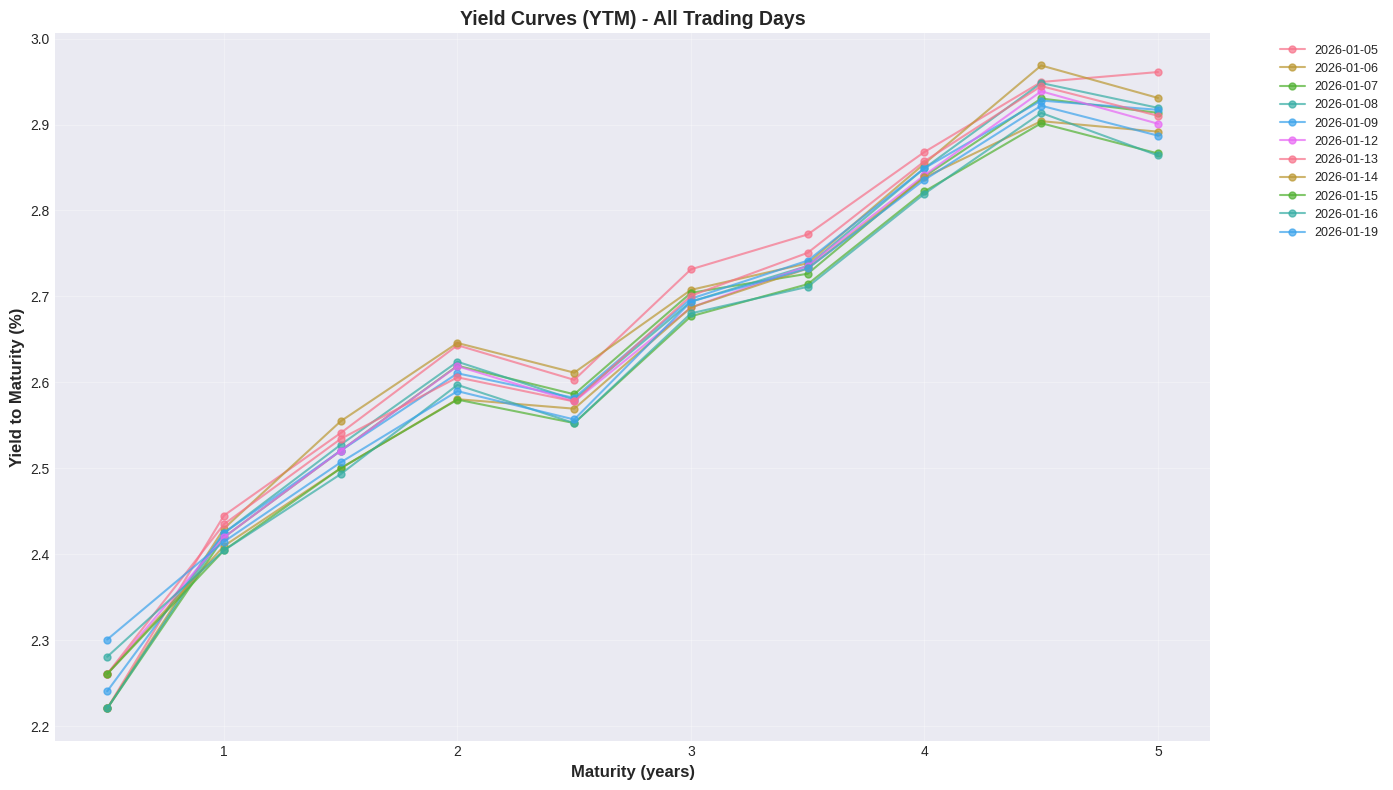

YTM curves plotted!


In [6]:
# Plot YTM curves (no smoothing)
plt.figure(figsize=(14, 8))

for date in ytm_df['Date'].unique():
    df_date = ytm_df[ytm_df['Date'] == date].sort_values('T')
    plt.plot(df_date['T'], df_date['YTM'] * 100,
            marker='o', markersize=5, linewidth=1.5,
            label=date.strftime('%Y-%m-%d'), alpha=0.7)

plt.xlabel('Maturity (years)', fontsize=12, fontweight='bold')
plt.ylabel('Yield to Maturity (%)', fontsize=12, fontweight='bold')
plt.title('Yield Curves (YTM) - All Trading Days', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ytm_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("YTM curves plotted!")

## Question 4(b): Spot Curve Bootstrapping

In [7]:
# Bootstrap spot curves for all dates
spot_all = []

for date in prices_long['Date'].unique():
    df_day = prices_long[prices_long['Date'] == date].copy()
    spot_day = bootstrap_one_day(df_day, date)
    spot_day['Date'] = date
    spot_all.append(spot_day)

spot_all_df = pd.concat(spot_all, ignore_index=True)
spot_all_df = spot_all_df[spot_all_df['T'] <= 5]

print("Spot curve bootstrapping complete!")
print(f"\nSample for {spot_all_df['Date'].min().date()}:")
print(spot_all_df[spot_all_df['Date'] == spot_all_df['Date'].min()][['T', 'Spot']])

Spot curve bootstrapping complete!

Sample for 2026-01-05:
     T      Spot
0  0.5  0.022205
1  1.0  0.024467
2  1.5  0.025432
3  2.0  0.026463
4  2.5  0.026043
5  3.0  0.027405
6  3.5  0.027778
7  4.0  0.028770
8  4.5  0.029639
9  5.0  0.029636


In [8]:
# Interpolate spot rates at 1, 2, 3, 4, 5 years
spot_1to5 = []

for date in spot_all_df['Date'].unique():
    df_day = spot_all_df[spot_all_df['Date'] == date].sort_values('T')
    
    if len(df_day) > 1:
        # Interpolate discount factors, then convert
        f_df = interp1d(df_day['T'], df_day['DF'], kind='linear', fill_value='extrapolate')
        
        for T in [1, 2, 3, 4, 5]:
            DF_interp = f_df(T)
            spot_interp = DF_to_spot(DF_interp, T)
            spot_1to5.append({'Date': date, 'T': T, 'Spot': spot_interp})

spot_1to5_df = pd.DataFrame(spot_1to5)

print("Spot rates at 1, 2, 3, 4, 5 years:")
print(spot_1to5_df[spot_1to5_df['Date'] == spot_1to5_df['Date'].min()])

Spot rates at 1, 2, 3, 4, 5 years:
        Date  T      Spot
0 2026-01-05  1  0.024467
1 2026-01-05  2  0.026463
2 2026-01-05  3  0.027405
3 2026-01-05  4  0.028770
4 2026-01-05  5  0.029636


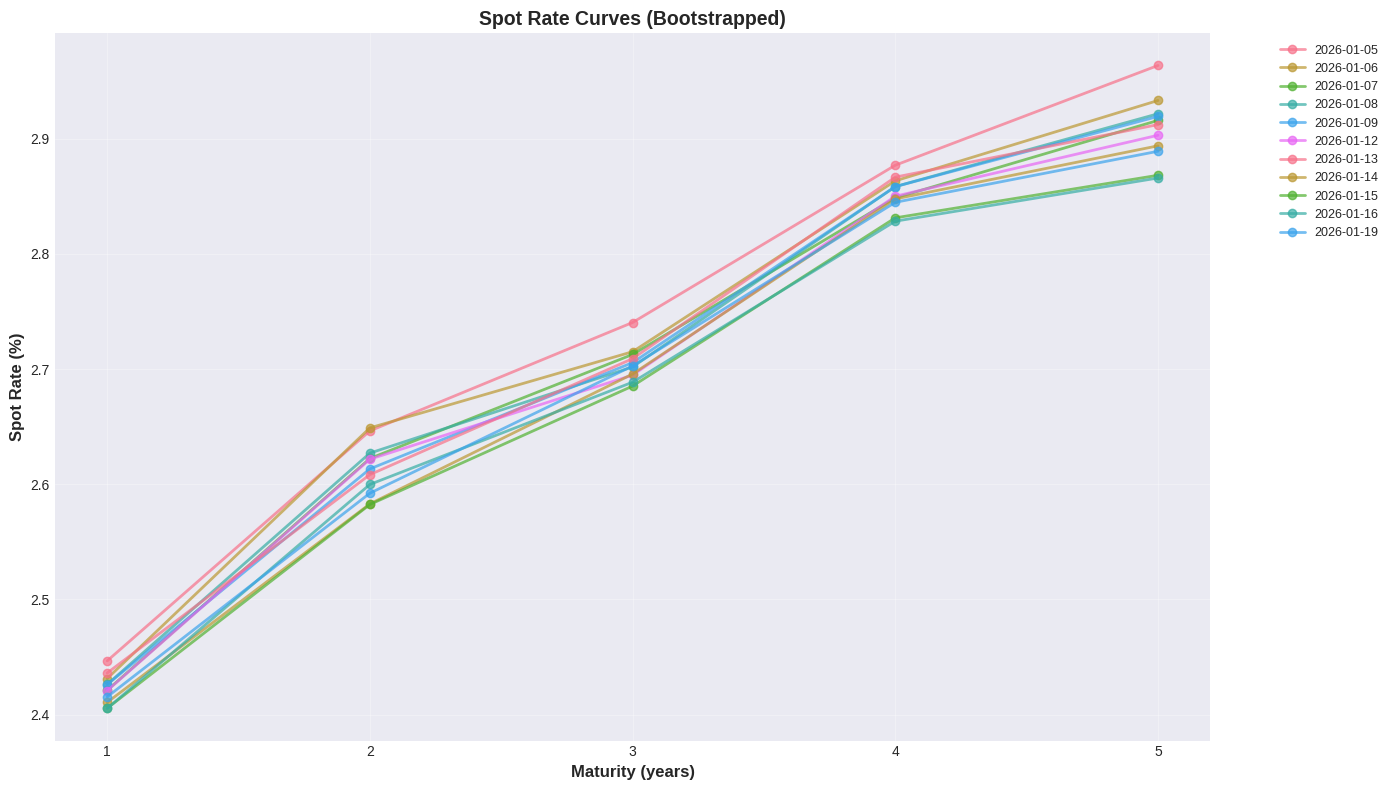

In [9]:
# Plot spot curves
plt.figure(figsize=(14, 8))

for date in spot_1to5_df['Date'].unique():
    df = spot_1to5_df[spot_1to5_df['Date'] == date]
    plt.plot(df['T'], df['Spot'] * 100,
            label=date.strftime('%Y-%m-%d'),
            linewidth=2, alpha=0.7, marker='o')

plt.xlabel('Maturity (years)', fontsize=12, fontweight='bold')
plt.ylabel('Spot Rate (%)', fontsize=12, fontweight='bold')
plt.title('Spot Rate Curves (Bootstrapped)', fontsize=14, fontweight='bold')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('spot_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

## Question 4(c): Forward Rates

In [10]:
# Calculate 1-year forward rates
# Pivot spot rates to wide format
spot_wide = spot_1to5_df.pivot(index='Date', columns='T', values='Spot')
spot_wide.columns = [f'S{int(c)}' for c in spot_wide.columns]

# Calculate forwards
forward_1yr = spot_wide.copy()
forward_1yr['F_1y1y'] = forward_1yr.apply(
    lambda row: forward_rate_sa(row['S1'], row['S2'], t=1, n=1), axis=1
)
forward_1yr['F_1y2y'] = forward_1yr.apply(
    lambda row: forward_rate_sa(row['S1'], row['S3'], t=1, n=2), axis=1
)
forward_1yr['F_1y3y'] = forward_1yr.apply(
    lambda row: forward_rate_sa(row['S1'], row['S4'], t=1, n=3), axis=1
)
forward_1yr['F_1y4y'] = forward_1yr.apply(
    lambda row: forward_rate_sa(row['S1'], row['S5'], t=1, n=4), axis=1
)

print("Forward rates calculated!")
print("\nSample:")
print(forward_1yr[['F_1y1y', 'F_1y2y', 'F_1y3y', 'F_1y4y']].head())

Forward rates calculated!

Sample:
              F_1y1y    F_1y2y    F_1y3y    F_1y4y
Date                                              
2026-01-05  0.014231  0.014438  0.015103  0.015465
2026-01-06  0.014334  0.014286  0.015038  0.015294
2026-01-07  0.014119  0.014293  0.014957  0.015199
2026-01-08  0.014140  0.014199  0.015014  0.015229
2026-01-09  0.014004  0.014228  0.015014  0.015215


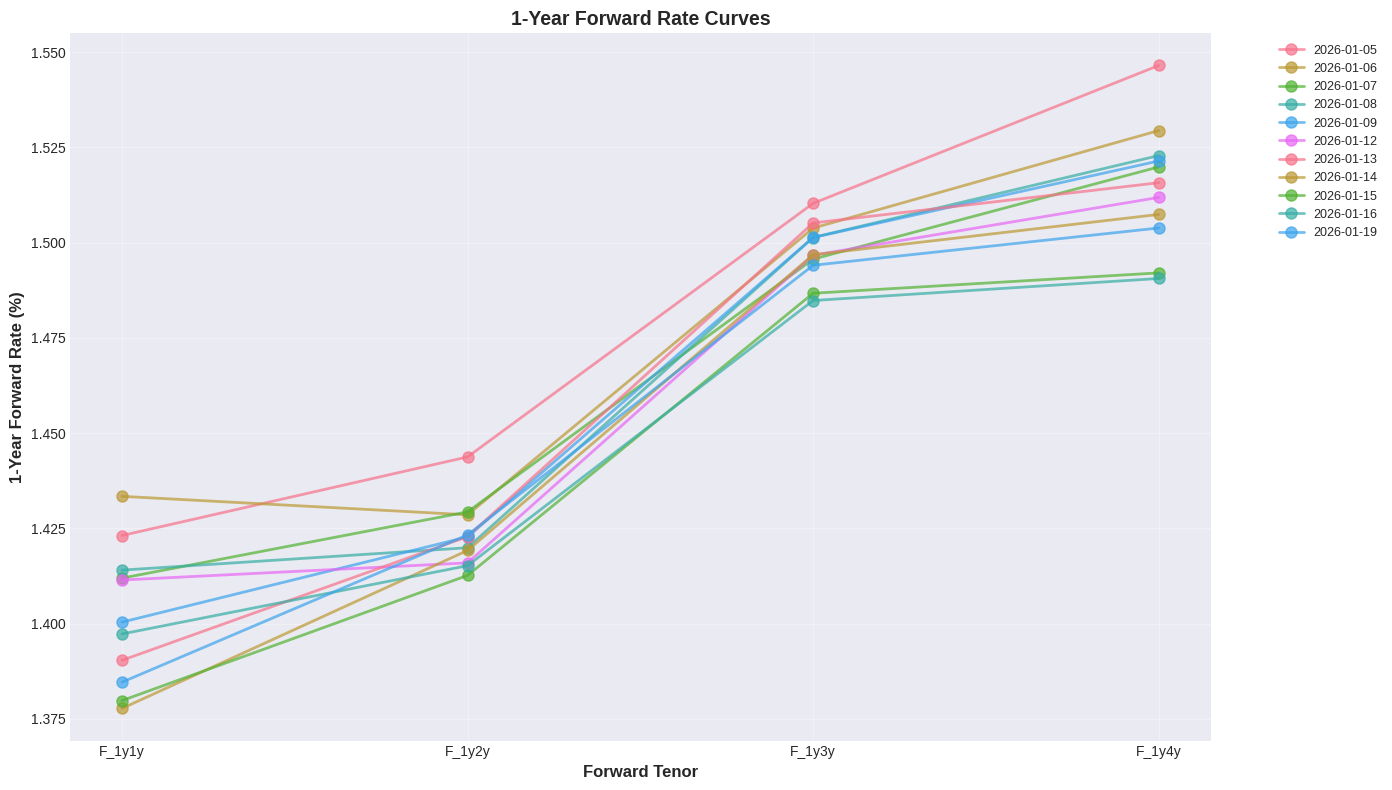

In [11]:
# Convert to long format for plotting
forward_cols = ['F_1y1y', 'F_1y2y', 'F_1y3y', 'F_1y4y']
forward_long = forward_1yr[forward_cols].reset_index().melt(
    id_vars='Date',
    value_vars=forward_cols,
    var_name='ForwardTenor',
    value_name='ForwardRate'
)

# Plot forward curves
plt.figure(figsize=(14, 8))

for date in forward_long['Date'].unique():
    df = forward_long[forward_long['Date'] == date]
    plt.plot(df['ForwardTenor'], df['ForwardRate'] * 100,
            label=date.strftime('%Y-%m-%d'),
            linewidth=2, alpha=0.7, marker='o', markersize=8)

plt.xlabel('Forward Tenor', fontsize=12, fontweight='bold')
plt.ylabel('1-Year Forward Rate (%)', fontsize=12, fontweight='bold')
plt.title('1-Year Forward Rate Curves', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('forward_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

## Question 5: Covariance Matrices

**IMPORTANT:** Following Ruth's approach, we use SPOT RATES (not YTM) for yield log-returns.
This is theoretically more correct as spot rates represent pure zero-coupon yields.

In [12]:
# Prepare yield rates matrix (using SPOT RATES)
yields_matrix = spot_1to5_df.pivot(index='Date', columns='T', values='Spot').sort_index()
yields_matrix.columns = [f'{int(c)}Y' for c in yields_matrix.columns]

print("Yield rates (spot rates) at 1, 2, 3, 4, 5 years:")
print(yields_matrix)

# Calculate log-returns
yield_log_returns = np.log(yields_matrix.shift(-1) / yields_matrix).iloc[:-1]

print(f"\nYield log-returns shape: {yield_log_returns.shape}")
print(yield_log_returns)

Yield rates (spot rates) at 1, 2, 3, 4, 5 years:
                  1Y        2Y        3Y        4Y        5Y
Date                                                        
2026-01-05  0.024467  0.026463  0.027405  0.028770  0.029636
2026-01-06  0.024313  0.026490  0.027151  0.028634  0.029332
2026-01-07  0.024211  0.026224  0.027127  0.028486  0.029159
2026-01-08  0.024262  0.026270  0.027019  0.028584  0.029217
2026-01-09  0.024261  0.026133  0.027056  0.028584  0.029194
2026-01-12  0.024208  0.026217  0.026948  0.028501  0.029030
2026-01-13  0.024361  0.026084  0.027091  0.028667  0.029123
2026-01-14  0.024106  0.025829  0.026957  0.028477  0.028939
2026-01-15  0.024055  0.025825  0.026853  0.028313  0.028683
2026-01-16  0.024054  0.025999  0.026886  0.028284  0.028659
2026-01-19  0.024154  0.025922  0.027027  0.028448  0.028891

Yield log-returns shape: (10, 5)
                  1Y        2Y        3Y        4Y        5Y
Date                                                        
20

Covariance Matrix - Yield (Spot Rate) Log-Returns:
          1Y            2Y        3Y        4Y            5Y
1Y  0.000025  7.261071e-06  0.000018  0.000021  2.365632e-05
2Y  0.000007  3.073326e-05 -0.000005  0.000004  5.352021e-07
3Y  0.000018 -4.568686e-06  0.000022  0.000016  2.257468e-05
4Y  0.000021  3.722220e-06  0.000016  0.000022  2.590795e-05
5Y  0.000024  5.352021e-07  0.000023  0.000026  3.417377e-05


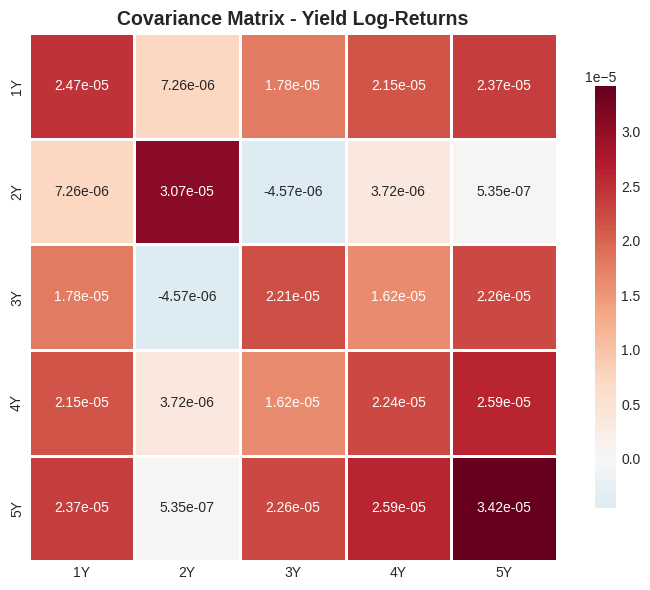

In [13]:
# Covariance matrix for yields
cov_yields = yield_log_returns.cov()

print("Covariance Matrix - Yield (Spot Rate) Log-Returns:")
print(cov_yields)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cov_yields, annot=True, fmt='.2e', cmap='RdBu_r',
            center=0, square=True, linewidths=1,
            cbar_kws={'shrink': 0.8})
plt.title('Covariance Matrix - Yield Log-Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('cov_yields_final.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Prepare forward rates matrix
forward_matrix = forward_1yr[forward_cols].sort_index()
forward_matrix.columns = ['1y1y', '1y2y', '1y3y', '1y4y']

print("Forward rates:")
print(forward_matrix)

# Calculate log-returns
forward_log_returns = np.log(forward_matrix.shift(-1) / forward_matrix).iloc[:-1]

print(f"\nForward log-returns shape: {forward_log_returns.shape}")
print(forward_log_returns)

Forward rates:
                1y1y      1y2y      1y3y      1y4y
Date                                              
2026-01-05  0.014231  0.014438  0.015103  0.015465
2026-01-06  0.014334  0.014286  0.015038  0.015294
2026-01-07  0.014119  0.014293  0.014957  0.015199
2026-01-08  0.014140  0.014199  0.015014  0.015229
2026-01-09  0.014004  0.014228  0.015014  0.015215
2026-01-12  0.014114  0.014159  0.014967  0.015119
2026-01-13  0.013904  0.014228  0.015052  0.015157
2026-01-14  0.013777  0.014192  0.014968  0.015074
2026-01-15  0.013798  0.014126  0.014867  0.014921
2026-01-16  0.013973  0.014152  0.014848  0.014906
2026-01-19  0.013846  0.014233  0.014941  0.015039

Forward log-returns shape: (10, 4)
                1y1y      1y2y      1y3y      1y4y
Date                                              
2026-01-05  0.007205 -0.010582 -0.004314 -0.011111
2026-01-06 -0.015099  0.000536 -0.005436 -0.006260
2026-01-07  0.001492 -0.006605  0.003794  0.001955
2026-01-08 -0.009704  0.002001 

Covariance Matrix - Forward Log-Returns:
          1y1y      1y2y      1y3y      1y4y
1y1y  0.000102 -0.000031 -0.000013 -0.000022
1y2y -0.000031  0.000028  0.000014  0.000024
1y3y -0.000013  0.000014  0.000023  0.000028
1y4y -0.000022  0.000024  0.000028  0.000039


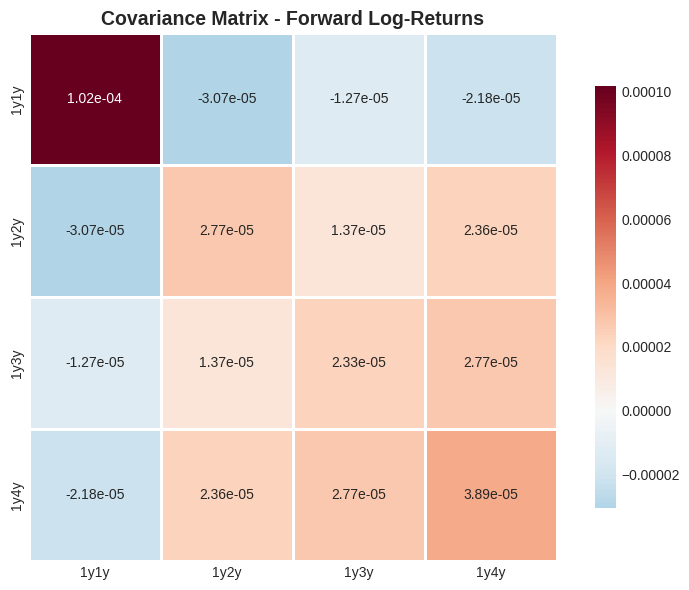

In [15]:
# Covariance matrix for forwards
cov_forwards = forward_log_returns.cov()

print("Covariance Matrix - Forward Log-Returns:")
print(cov_forwards)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cov_forwards, annot=True, fmt='.2e', cmap='RdBu_r',
            center=0, square=True, linewidths=1,
            cbar_kws={'shrink': 0.8})
plt.title('Covariance Matrix - Forward Log-Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('cov_forwards_final.png', dpi=300, bbox_inches='tight')
plt.show()

## Question 6: Principal Component Analysis

In [16]:
# Eigendecomposition - Yields
eigenvalues_y, eigenvectors_y = np.linalg.eig(cov_yields)
idx_y = eigenvalues_y.argsort()[::-1]
eigenvalues_y = eigenvalues_y[idx_y]
eigenvectors_y = eigenvectors_y[:, idx_y]

print("="*80)
print("YIELD COVARIANCE MATRIX - PCA")
print("="*80)

print("\nEigenvalues:")
for i, val in enumerate(eigenvalues_y, 1):
    var_pct = (val / eigenvalues_y.sum()) * 100
    print(f"  PC{i}: {val:.6e} ({var_pct:.2f}% of variance)")

print("\nEigenvectors:")
eigenvec_y_df = pd.DataFrame(
    eigenvectors_y,
    index=cov_yields.columns,
    columns=[f'PC{i}' for i in range(1, len(eigenvalues_y)+1)]
)
print(eigenvec_y_df)

print("\n" + "="*80)
print("INTERPRETATION:")
print(f"PC1 explains {(eigenvalues_y[0]/eigenvalues_y.sum())*100:.2f}% of variance.")
print("Represents the dominant mode of yield curve variation.")
print("="*80)

YIELD COVARIANCE MATRIX - PCA

Eigenvalues:
  PC1: 9.107853e-05 (67.89% of variance)
  PC2: 3.330065e-05 (24.82% of variance)
  PC3: 5.523817e-06 (4.12% of variance)
  PC4: 3.895756e-06 (2.90% of variance)
  PC5: 3.484633e-07 (0.26% of variance)

Eigenvectors:
         PC1       PC2       PC3       PC4       PC5
1Y -0.486507 -0.161134  0.308737  0.663969 -0.448524
2Y -0.061023 -0.949536  0.111521 -0.277034  0.073974
3Y -0.426548  0.246695  0.720006 -0.379572  0.307758
4Y -0.478973 -0.051393 -0.408394  0.307328  0.711834
5Y -0.590109  0.094432 -0.455028 -0.493834 -0.438100

INTERPRETATION:
PC1 explains 67.89% of variance.
Represents the dominant mode of yield curve variation.


In [17]:
# Eigendecomposition - Forwards
eigenvalues_f, eigenvectors_f = np.linalg.eig(cov_forwards)
idx_f = eigenvalues_f.argsort()[::-1]
eigenvalues_f = eigenvalues_f[idx_f]
eigenvectors_f = eigenvectors_f[:, idx_f]

print("="*80)
print("FORWARD COVARIANCE MATRIX - PCA")
print("="*80)

print("\nEigenvalues:")
for i, val in enumerate(eigenvalues_f, 1):
    var_pct = (val / eigenvalues_f.sum()) * 100
    print(f"  PC{i}: {val:.6e} ({var_pct:.2f}% of variance)")

print("\nEigenvectors:")
eigenvec_f_df = pd.DataFrame(
    eigenvectors_f,
    index=cov_forwards.columns,
    columns=[f'PC{i}' for i in range(1, len(eigenvalues_f)+1)]
)
print(eigenvec_f_df)
print("="*80)

FORWARD COVARIANCE MATRIX - PCA

Eigenvalues:
  PC1: 1.291269e-04 (67.35% of variance)
  PC2: 5.093704e-05 (26.57% of variance)
  PC3: 1.021814e-05 (5.33% of variance)
  PC4: 1.446330e-06 (0.75% of variance)

Eigenvectors:
           PC1       PC2       PC3       PC4
1y1y -0.819488  0.537736  0.196720 -0.024090
1y2y  0.366364  0.231319  0.861426 -0.264979
1y3y  0.242279  0.503471 -0.452109 -0.695280
1y4y  0.368127  0.635491 -0.121832  0.667676


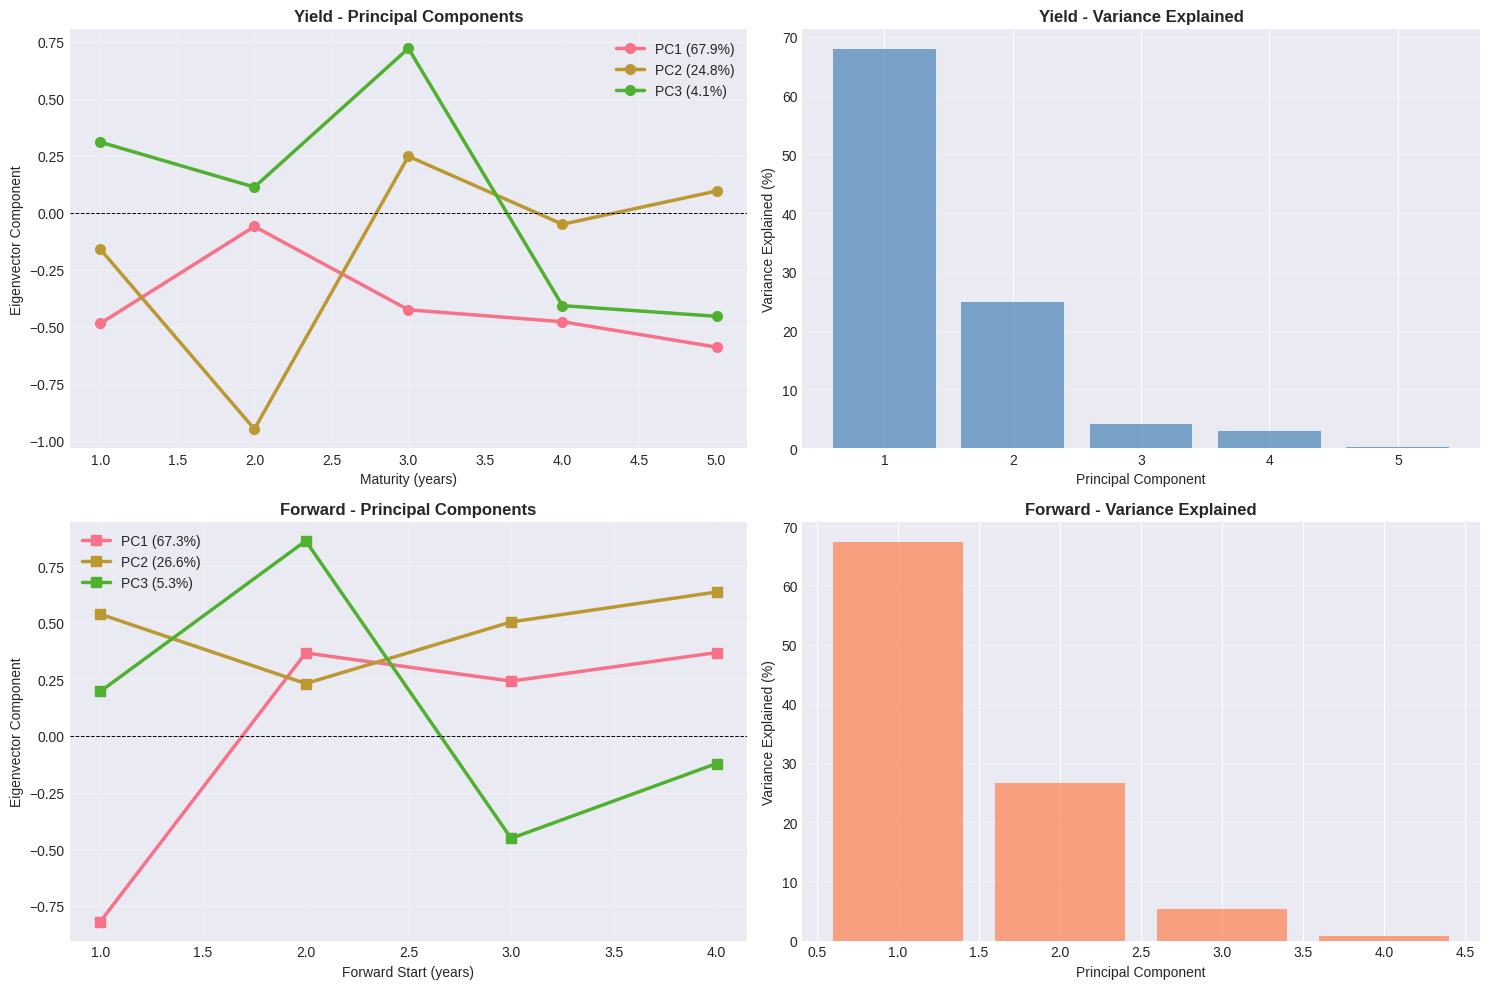

In [18]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Yields - Eigenvectors
for i in range(min(3, len(eigenvalues_y))):
    var_pct = (eigenvalues_y[i] / eigenvalues_y.sum()) * 100
    axes[0, 0].plot([1, 2, 3, 4, 5], eigenvectors_y[:, i],
                   marker='o', linewidth=2.5, markersize=7,
                   label=f'PC{i+1} ({var_pct:.1f}%)')

axes[0, 0].set_title('Yield - Principal Components', fontsize=12, weight='bold')
axes[0, 0].set_xlabel('Maturity (years)')
axes[0, 0].set_ylabel('Eigenvector Component')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='k', linewidth=0.7, linestyle='--')

# Yields - Variance explained
var_exp_y = (eigenvalues_y / eigenvalues_y.sum()) * 100
axes[0, 1].bar(range(1, len(var_exp_y)+1), var_exp_y, color='steelblue', alpha=0.7)
axes[0, 1].set_title('Yield - Variance Explained', fontsize=12, weight='bold')
axes[0, 1].set_xlabel('Principal Component')
axes[0, 1].set_ylabel('Variance Explained (%)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Forwards - Eigenvectors
for i in range(min(3, len(eigenvalues_f))):
    var_pct = (eigenvalues_f[i] / eigenvalues_f.sum()) * 100
    axes[1, 0].plot([1, 2, 3, 4], eigenvectors_f[:, i],
                   marker='s', linewidth=2.5, markersize=7,
                   label=f'PC{i+1} ({var_pct:.1f}%)')

axes[1, 0].set_title('Forward - Principal Components', fontsize=12, weight='bold')
axes[1, 0].set_xlabel('Forward Start (years)')
axes[1, 0].set_ylabel('Eigenvector Component')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='k', linewidth=0.7, linestyle='--')

# Forwards - Variance explained
var_exp_f = (eigenvalues_f / eigenvalues_f.sum()) * 100
axes[1, 1].bar(range(1, len(var_exp_f)+1), var_exp_f, color='coral', alpha=0.7)
axes[1, 1].set_title('Forward - Variance Explained', fontsize=12, weight='bold')
axes[1, 1].set_xlabel('Principal Component')
axes[1, 1].set_ylabel('Variance Explained (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pca_analysis_final.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary and Export

In [19]:
print("="*80)
print("PCA SUMMARY")
print("="*80)

print("\nYIELD CURVES:")
cumvar_y = np.cumsum(eigenvalues_y) / eigenvalues_y.sum() * 100
for i, (var, cumvar) in enumerate(zip(var_exp_y, cumvar_y), 1):
    print(f"  PC{i}: {var:6.2f}% (Cumulative: {cumvar:6.2f}%)")

print("\nFORWARD RATES:")
cumvar_f = np.cumsum(eigenvalues_f) / eigenvalues_f.sum() * 100
for i, (var, cumvar) in enumerate(zip(var_exp_f, cumvar_f), 1):
    print(f"  PC{i}: {var:6.2f}% (Cumulative: {cumvar:6.2f}%)")

print("\n" + "="*80)

PCA SUMMARY

YIELD CURVES:
  PC1:  67.89% (Cumulative:  67.89%)
  PC2:  24.82% (Cumulative:  92.72%)
  PC3:   4.12% (Cumulative:  96.84%)
  PC4:   2.90% (Cumulative:  99.74%)
  PC5:   0.26% (Cumulative: 100.00%)

FORWARD RATES:
  PC1:  67.35% (Cumulative:  67.35%)
  PC2:  26.57% (Cumulative:  93.92%)
  PC3:   5.33% (Cumulative:  99.25%)
  PC4:   0.75% (Cumulative: 100.00%)



In [20]:
# Export results
yields_matrix.to_csv('yields_final.csv')
forward_matrix.to_csv('forwards_final.csv')
yield_log_returns.to_csv('yield_logreturns_final.csv')
forward_log_returns.to_csv('forward_logreturns_final.csv')
cov_yields.to_csv('cov_yields_final.csv')
cov_forwards.to_csv('cov_forwards_final.csv')
eigenvec_y_df.to_csv('eigenvectors_yields_final.csv')
eigenvec_f_df.to_csv('eigenvectors_forwards_final.csv')

pd.DataFrame({
    'PC': [f'PC{i}' for i in range(1, len(eigenvalues_y)+1)],
    'Eigenvalue': eigenvalues_y,
    'Variance_%': var_exp_y,
    'Cumulative_%': cumvar_y
}).to_csv('pca_yields_final.csv', index=False)

pd.DataFrame({
    'PC': [f'PC{i}' for i in range(1, len(eigenvalues_f)+1)],
    'Eigenvalue': eigenvalues_f,
    'Variance_%': var_exp_f,
    'Cumulative_%': cumvar_f
}).to_csv('pca_forwards_final.csv', index=False)

print("All results exported successfully!")

All results exported successfully!
